In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import nonlinear_QM_FPJPA as Fs
import wx_programs as wx
import bnc
from generator import *
from hardware_config import *
from values import *
from qubit_class import *
import daq.daq_programs_homo as daq
import standard_sequences.rabi as rabi
from analysis.analysis import *
import standard_sequences.rabi_ef_swap as rabi_ef_swap

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

q2.ro_amp = 0.2
# q2.ge_time = 98.9371236588114
# q2.ef_time = 130.05199911088016
# q2.ef_amp = 2.5
print(f"{q1}\n{q2}")

Qubit(RO_LO_pwr=16, ro_freq=6.7275, IQ_angle=205, ro_amp=0.5, ef_time=78.05067663337411, ge_amp=1.2, RO_LO=6.6247, ge_time=52.35258023759522, qubit_id=q1, ROq3=6.583064, ro_dur=5000, ef_ssm=-0.255, ge_ssm=-0.11, ef_amp=1, ROIF=0.10280000000000022, qubit_thr=[-10000, -600])
Qubit(RO_LO_pwr=16, ro_freq=6.65555, IQ_angle=85, ro_amp=0.5, ef_time=None, ge_amp=1.2, RO_LO=6.6247, ge_time=40.15374412400174, qubit_id=q2, ROq3=6.583064, ro_dur=5000, ef_ssm=-0.224, ge_ssm=-0.152, ef_amp=1, ROIF=0.030850000000000044, qubit_thr=[-10000, 2500])
Qubit(RO_LO_pwr=16, ro_freq=6.7275, IQ_angle=205, ro_amp=0.5, ef_time=78.05067663337411, ge_amp=1.2, RO_LO=6.6247, ge_time=52.35258023759522, qubit_id=q1, ROq3=6.583064, ro_dur=5000, ef_ssm=-0.255, ge_ssm=-0.11, ef_amp=1, ROIF=0.10280000000000022, qubit_thr=[-10000, -600])
Qubit(RO_LO_pwr=16, ro_freq=6.65555, IQ_angle=85, ro_amp=0.2, ef_time=None, ge_amp=1.2, RO_LO=6.6247, ge_time=40.15374412400174, qubit_id=q2, ROq3=6.583064, ro_dur=5000, ef_ssm=-0.224, ge_s

In [14]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
num_steps = 51
reps = 500
sweep_time=20000
swap_freq=0.1
swap_time=100

In [15]:
rabi_ef_swap.rabi_ef_swap(q1, q2, general_vals_dict, num_steps,sweep_time, swap_freq = swap_freq,swap_time = swap_time)

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error


0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 500
Buffers per acquistion: 9
DAQ samples per pattern: 8192
0, No error
Capturing 9 buffers. Press <enter> to abort
Capture completed in 3.792998 sec
Captured 9 buffers (2.372793 buffers per sec)
Captured 27648 records (7289.220677 records per sec)
Transferred 452984832 bytes (119426591.573488 bytes per sec)


<Figure size 800x800 with 0 Axes>

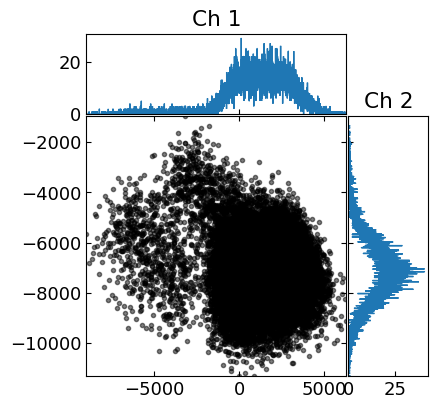

<Figure size 800x800 with 0 Axes>

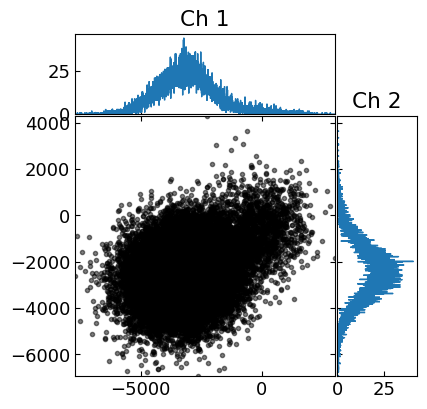

In [16]:
wx.wx_set_and_amplitude_and_offset(
    amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
)
values = daq.run_daq_het_2q(q1, q2,
                   num_patterns=num_steps, num_records_per_pattern=reps,
                    verbose=True)

RuntimeError


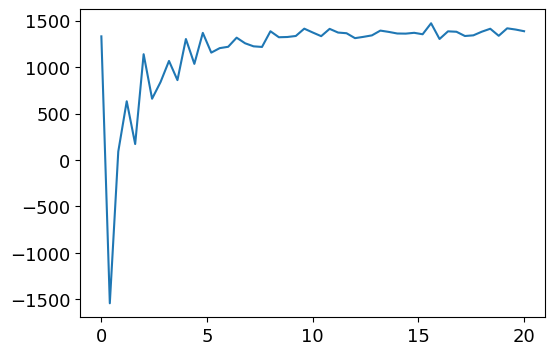



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
π_ge time = nan ns


In [17]:
which_qubit = 1
if 1 == which_qubit:
    I_Q1 = values.rec_avg_vs_pats_1[0]
    Q_Q1 = values.rec_avg_vs_pats_1[1]
    I = I_Q1
    Q = Q_Q1
elif 2 == which_qubit:
    I_Q2 = values.rec_avg_vs_pats_2[0]
    Q_Q2 = values.rec_avg_vs_pats_2[1]
    I = I_Q2
    Q = Q_Q2
Qrange = abs(np.max(Q)-np.min(Q))
Irange = abs(np.max(I)-np.min(I))
if Qrange>Irange:
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = fit_sine_decay(times,Q,guess_vals=[11,0.3,np.abs(np.max(Q)-np.min(Q)),38,Q[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
else:    
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = fit_sine_decay(times,I,guess_vals=[11,0.3,np.abs(np.max(I)-np.min(I)),38,I[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
    


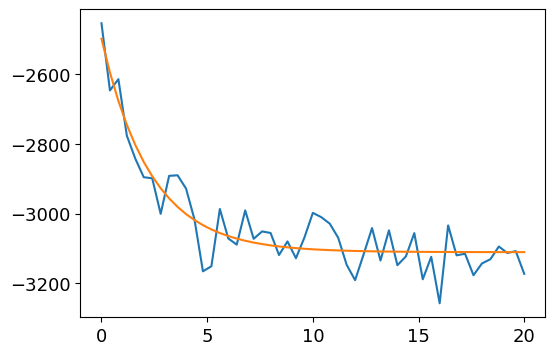



  freq: 9.999999995760684 +/- 2172.8402332414184
 gamma: 0.4306238616104888 +/- 143386.38283437592
   amp: 6464.117562327371 +/- 108901432.98325841
 phase: 5.438955978698038 +/- 91906.56330985033
offset: -3110.523288486364 +/- 14.41908829105701
pi_pulse time: 0.05000000002119658 +/- 2172.8402332414184
π_ge time = 50.000000021196584 ns


In [18]:
which_qubit = 2
if 1 == which_qubit:
    I_Q1 = values.rec_avg_vs_pats_1[0]
    Q_Q1 = values.rec_avg_vs_pats_1[1]
    I = I_Q1
    Q = Q_Q1
elif 2 == which_qubit:
    I_Q2 = values.rec_avg_vs_pats_2[0]
    Q_Q2 = values.rec_avg_vs_pats_2[1]
    I = I_Q2
    Q = Q_Q2
Qrange = abs(np.max(Q)-np.min(Q))
Irange = abs(np.max(I)-np.min(I))
if Qrange>Irange:
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = fit_sine_decay(times,Q,guess_vals=[11,0.3,np.abs(np.max(Q)-np.min(Q)),38,Q[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
else:    
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = fit_sine_decay(times,I,guess_vals=[11,0.3,np.abs(np.max(I)-np.min(I)),38,I[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
    